In [377]:
import numpy as np
import copy
import script.scan as sc
import script.data as data
import script.model as sim

In [254]:
KT = 4.14 # pN * nm
K0 = 1

In [255]:
np.random.seed(10)

def sample_binom(n, p):
    return np.random.binomial(n, p)

def sample_nag(N, ka, kb):
    p = ka / (ka + kb)
    return sample_binom(N, p)

In [343]:
class Bond:
    """General bond"""
    def __init__(self, E, f, x):
        self.koff = K0 * np.exp(-E + f*x/KT)
        self.E = E
        self.f = f
        self.x = x
        
class APC(Bond):
    """APC tether bond"""
    def __init(self, Ea, f, xa=1.5):
        super().__init__(Ea, f, xa)

class Bcell(Bond):
    """B cell """
    def __init__(self, Eb, f, xb=2.0, N=100):
        super().__init__(Eb, f, xb)
        self.N = N
        self.nag = 0  
    
    def extract_from_APC(self, apc):
        self.nag = sample_nag(self.N, apc.koff, self.koff)
        return self.nag
    
    def extract_from_another_bcell(self, bcell):
        nag0 = self.nag + bcell.nag
        self.nag = sample_nag(nag0, bcell.koff, self.koff)
        bcell.nag = nag0 - self.nag
        return
    
    def __gt__(self, other):
        return self.nag - other.nag
    
    def __ge__(self, other):
        return self.nag >= other.nag
    
class GC:
    
    def __init__(self, prm=None, seed=0):
        '''
        prm is the config dictionary
        '''
        if prm is None:
            ## for testing
            prm = {
                'Ea': 10,
                'xa': 1.5,
                'Eb': 5,
                'xb': 2.0,
                'f': 0,
                'Nb': 2, # num of B cells
                'dEb': 0.1, # gap
                'N': 200,
                'Bcell_sample_mode': 'fixed_gap', # 'random_gaussian', 'fixed_gap',
                'env':  'development',
                'num_runs': 2,
                'num_repeats': 2,
                'num_of_competes': 1,
                'inter_competition': True,
            }
        self.seed = seed
        self.saved_qty = ['fidelity']
        self.load_prm(prm)
        
        
    def load_prm(self, prm):
        self.prm = copy.deepcopy(prm)
        self.reset()
        self.setup()
        
    def reset(self):
        self.bcells = []
        self.Eblist = []
        self.apc = None
        self.fidelity = 0
        self.correctness = 0
        self.dataset = data.MyData()
        #np.random.seed(self.seed)
        
    def set_prm(self, name, val):
        self.prm[name] = val
        self.load_prm(self.prm)
        
        
    def get(self, qty):
        if qty in self.prm:
            return self.prm[qty]
        else:
            raise Exception('No such parameter in the prm dict: %s' % qty)
        
    def sample_Bcells(self, mode = "fixed_gap"):
        '''
        mode options: 
            - fixed_gap: diff by a fixed amount: [0, 0.2, 0.4, ....]
            - random_uniform: sampled form uniform distribution: [0.24,0.14, 0.43]
            - random_gaussian: sampled form a Gaussian distribution: [0.32, 0.42, 0.234]
            - constant: constant affinity
        '''
        self.log('initializing B cells, mode=' + mode + ', ....', level='debug')
        if mode == 'constant':
            Eblist = [self.get('Eb')] * self.get('Nb')
        elif mode == 'fixed_gap':
            Eblist = [self.get('Eb') + i * self.get('dEb') for i in range(self.get('Nb'))]
        elif mode == 'random_uniform':
            Eblist = np.random.uniform(
                low=self.get('Eb') - self.get('dEb')/2, 
                high=self.get('Eb') + self.get('dEb')/2,
                size = self.get('Nb')
            )
        elif mode == 'random_gaussian':
            Eblist = np.random.normal(loc=self.get('Eb'), scale=self.get('dEb'), size=self.get('Nb'))
        else:
            raise Exception('Mode undefined: %s' % mode)
        self.Eblist = Eblist
        self.log('B cell initialized! affinity list: ' + ','.join([str(eb) for eb in self.Eblist]), level='debug')
        return np.asarray([Bcell(Eb, self.get('f'), self.get('xb'), self.get('N')) for Eb in Eblist])
    
    def setup(self):
        self.log('start setup....', level='debug')
        self.apc = APC(self.get('Ea'), self.get('f'), self.get('xa'))
        self.bcells = self.sample_Bcells(mode=self.get('Bcell_sample_mode'))
        self.test_setup()
        self.log('setup done! ', level='debug')
    
    def test_setup(self):
        if self.apc is None:
            raise Exception('APC is not initialized')
        if len(self.bcells) != self.get('Nb'):
            raise Exception('B cells are not initialized correctly')
        return 
    
    def extract(self):
        self.log('start antigen extraction .... ', level='debug')
        for bcell in self.bcells:
            bcell.extract_from_APC(self.apc)
        self.log('antigen extraction done!', level='debug')
        return 
    
    def compete(self):
        self.log('start compete ....', level='debug')
        for _ in range(self.get('num_of_competes')):
            bcell1, bcell2 = np.random.choice(self.bcells, size=2, replace=False)
            self.log('chosen two B cells: ' + str(bcell1.E) + ' vs ' + str(bcell2.E), level='debug')
            bcell1.extract_from_another_bcell(bcell2)
            self.log('compete results: ' + str(bcell1.nag) + ' : ' + str(bcell2.nag), level='debug')
        self.log('compete done!', level='debug')
        return 
    
    def check_ranking(self):
        self.log('check ranking....', level='debug')
        best_bcell_id = np.argmax(self.Eblist)
        # selected_bcell_id = np.argmax(np.array(self.bcells))
        nag_list = np.asarray([bcell.nag for bcell in self.bcells])
        selected_bcell_id = np.random.choice(
            np.flatnonzero(nag_list == nag_list.max())
        )
        self.log('best bcell: ' + str(best_bcell_id), level='debug')
        self.log('selected Bcell: ' + str(selected_bcell_id), level='debug')
        return selected_bcell_id == best_bcell_id
    
    def run_one_step(self):
        self.extract()
        if self.get('inter_competition'):
            # direct competition between B cells 
            self.compete()
        if self.check_ranking():
            self.correctness += 1
        return
    
    def run_once(self):
        self.log('start running', level='debug')
        self.correctness = 0
        self.setup()
        for _ in range(self.get('num_runs')):
            self.log('start running once', level='debug')
            self.run_one_step()
            self.log('done running once. correctness={0:d}'.format(self.correctness), level='debug')
        self.fidelity = self.correctness / self.get('num_runs')
        self.log('done running, fidelity={0:.4f}'.format(self.fidelity), level='debug')
        return self.fidelity
    
    def run(self):
        self.log('many run starts, repeats = ' + str(self.get('num_repeats')) + ', .....', level='info')
        self.fidelity_list = []
        for i in range(self.get('num_repeats')):
            fid  = self.run_once()
            self.fidelity_list.append(fid)
            self.dataset.append('fidelity', fid)
            self.log('> ' + str(i) + ': fid = ' + str(fid), level='debug')
        self.log('>>>>> sum: mean ={0:.4f}; std={1:.4f}'.format(np.mean(self.fidelity_list), np.std(self.fidelity_list)), level='info')
        return True
    
    
    def save(self):
        pass
        return
    
    def log(self, message, level):
        levels = {
            'debug': 0,
            'info': 1,
        }
        env = self.get('env')
        if env == 'production':
            return 
        elif env == 'development':
            print(message)
        else:
            if levels[level] > 0:
                print(message)
        return 
    
    def get_data(self):
        return self.dataset

In [344]:
## test
gc = GC()
gc.run()

start setup....
initializing B cells, mode=fixed_gap, ....
B cell initialized! affinity list: 5.0,5.1
setup done! 
many run starts, repeats = 2, .....
start running
start setup....
initializing B cells, mode=fixed_gap, ....
B cell initialized! affinity list: 5.0,5.1
setup done! 
start running once
start antigen extraction .... 
antigen extraction done!
start compete ....
chosen two B cells: 5.1 vs 5.0
compete results: 1 : 1
compete done!
check ranking....
best bcell: 1
selected Bcell: 1
done running once. correctness=1
start running once
start antigen extraction .... 
antigen extraction done!
start compete ....
chosen two B cells: 5.0 vs 5.1
compete results: 1 : 0
compete done!
check ranking....
best bcell: 1
selected Bcell: 0
done running once. correctness=1
done running, fidelity=0.5000
> 0: fid = 0.5
start running
start setup....
initializing B cells, mode=fixed_gap, ....
B cell initialized! affinity list: 5.0,5.1
setup done! 
start running once
start antigen extraction .... 
antige

True

In [415]:
prm = {
    'Ea': 10,
    'xa': 1.5,
    'Eb': 5,
    'xb': 2.0,
    'f': 0,
    'Nb': 2, # num of B cells
    'dEb': 0.5, # gap
    'N': 20,
    'Bcell_sample_mode': 'fixed_gap', # 'random_gaussian', 'fixed_gap',
    'env': 'experiment', # 'development',
    'num_runs': 500,
    'num_repeats': 10,
    'num_of_competes': 1,
    'inter_competition': True,
    
    ### scanner prm ###
    'prm_name': 'Eb',
    'prm_list_prm': [5, 16.5, 0.5],
    'unit':1,
    'prm_scale': 'linear',
    'dir': 'data/test/',
}

In [379]:
# prm['dir'] = 'data/baseline'
prm['inter_competition'] = True
gc = GC(prm=prm)
scanner = sc.Scaner(agent=gc, double_prm=False)
scanner.prm = prm
scanner.save_agent_data = False
scanner.load_config(prm)
scanner.save=False

In [380]:

scanner.run()

[Scaner]:: ...loaded the job parameters successfully. 
[Scaner]:: ...PID:8949
[Scaner]:: start running ........
[Scaner]:: >>temp saved data:data/baseline/data_temp
[Scaner]:: >> prm_name=Eb, prm_list=[5.000,5.500,6.000,6.500,7.000,7.500,8.000,8.500,9.000,9.500,10.000,10.500,11.000,11.500,12.000,12.500,13.000,13.500,14.000,14.500,15.000,15.500,16.000]
[Scaner]:: create check file:data/baseline/check
[Scaner]:: ******************** now on Eb=5.000e+00********************
many run starts, repeats = 10, .....
>>>>> sum: mean =0.5060; std=0.0218
[Scaner]:: ******************** now on Eb=5.500e+00********************
many run starts, repeats = 10, .....
>>>>> sum: mean =0.5166; std=0.0208
[Scaner]:: ******************** now on Eb=6.000e+00********************
many run starts, repeats = 10, .....
>>>>> sum: mean =0.5126; std=0.0299
[Scaner]:: ******************** now on Eb=6.500e+00********************
many run starts, repeats = 10, .....
>>>>> sum: mean =0.5162; std=0.0233
[Scaner]:: ******

In [373]:
dt1 = data.MyData()
dt1.load('data/baseline/with_compete/data_temp.json')

9.97504160771568
0.0907556908941612


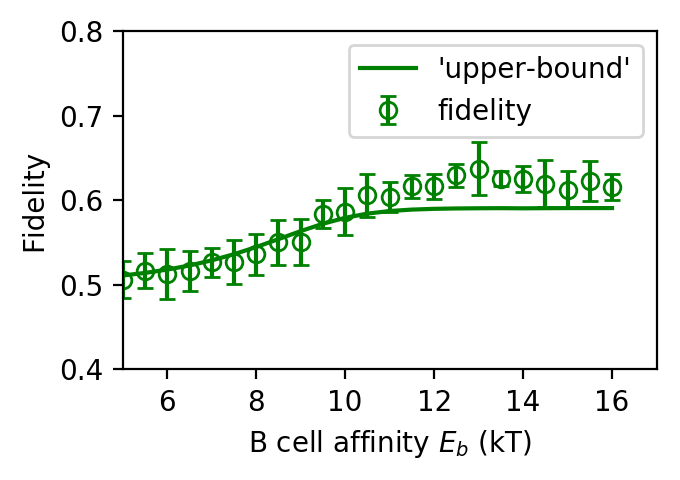

In [414]:
from matplotlib import pyplot as plt
N = 20
nB = 2
dE = 0.1
Fisher_info_nag_post_comp = 2 * N * np.exp(dE) / (1 + np.exp(dE))**2
mu, sigma = cdf(0.1, 2*N, v=nB-1)
print(Fisher_info_nag_post_comp)
print(sigma*np.sqrt(Fisher_info_nag_post_comp)*dE)


sc_plot = sc.ScanPlot(scaner=scanner)
fig, ax = plt.subplots(figsize=(3.5, 2.5), dpi=200)
sc_plot.plot_qty('fidelity', errorbar=True, ax=ax, color='g')
plt.plot(np.arange(5, 16.5, 0.5), mu + sigma*np.sqrt(infoList)*dE, '-g')
#ax.plot( np.linspace(13, 16, 20) , [mu+sigma*np.sqrt(Fisher_info_nag_post_comp)*2*dE]*20, '--C0')
#ax.plot(np.arange(5, 16.5, 0.5), aucList,'-C0' )
ax.set(xlim=(5, 17), ylim=(0.4, 0.8))
plt.xlabel('B cell affinity $E_b$ (kT)')
plt.ylabel('Fidelity')
plt.legend([ "'upper-bound'", "fidelity"])
plt.tight_layout()
plt.show()

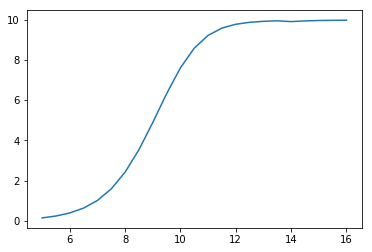

In [407]:
#infoList = np.asarray([0.147229, 0.240949, 0.392476, 0.634447, 1.01323, 1.58775, 2.41764, \
#3.5322, 4.88257, 6.31159, 7.5985, 8.57529, 9.20853, 9.5714, 9.76381, \
#9.8626, 9.9135, 9.94039])
infoList = np.asarray([
    0.147229, 0.24095, 0.392476, 0.634449, 1.01324, 1.58778, 2.41773, \
3.53251, 4.88348, 6.3138, 7.60283, 8.58198, 9.21676, 9.57965, \
9.77086, 9.86796, 9.91725, 9.94288, 9.90343, 9.93831, 9.95733, \
9.96661, 9.97094
])
plt.plot(np.arange(5, 16.5, 0.5), infoList)

aucList = np.asarray([0.506189, 0.509438, 0.51388, 0.519564, 0.526479, 0.534767, 0.544753, \
0.556718, 0.570711, 0.586404, 0.602978, 0.619181, 0.63368, 0.645532, \
0.654453, 0.660731, 0.664931, 0.667645, 0.669357, 0.670422, 0.671077, \
0.671478, 0.671723])

In [392]:
from scipy.special import binom

def binomPDF(eb, ni, n):
    eta = 1/(1+np.exp(-eb))
    return binom(n, ni)*eta**ni*((1-eta)**(n-ni))

def cdf(eb, n, v=1):
    
    pdf = np.empty(n+1)
    for i in range(0, n+1):
        pdf[i] = binomPDF(eb, i, n)
        
    cdf = np.empty(n+1)
    
    cdf[0] = pdf[0]/2
    for i in range(1, n+1):
        cdf[i] = cdf[i-1] + (pdf[i]+pdf[i-1])/2
    
    #print(cdf)
    
    s = 0
    for i in range(n+1):
        s += pdf[i]*cdf[i]**v
        
    t = 0 
    for i in range(n+1):
        t += pdf[i]*cdf[i]**(2*v)
    return s, np.sqrt(t-s**2)





# theoretical fidelity

In [416]:
# prm['dir'] = 'data/baseline'
prm['inter_competition'] = True
gc = GC(prm=prm)
scanner2 = sc.Scaner(agent=gc, double_prm=False)
scanner2.prm = prm
scanner2.save_agent_data = False
scanner2.load_config(prm)
scanner2.save=False

In [417]:
scanner2.run()

[Scaner]:: ...loaded the job parameters successfully. 
[Scaner]:: ...PID:8949
[Scaner]:: start running ........
[Scaner]:: >>temp saved data:data/test//data_temp
[Scaner]:: >> prm_name=Eb, prm_list=[5.000,5.500,6.000,6.500,7.000,7.500,8.000,8.500,9.000,9.500,10.000,10.500,11.000,11.500,12.000,12.500,13.000,13.500,14.000,14.500,15.000,15.500,16.000]
[Scaner]:: ******************** now on Eb=5.000e+00********************
many run starts, repeats = 10, .....
>>>>> sum: mean =0.5362; std=0.0197
[Scaner]:: ******************** now on Eb=5.500e+00********************
many run starts, repeats = 10, .....
>>>>> sum: mean =0.5614; std=0.0201
[Scaner]:: ******************** now on Eb=6.000e+00********************
many run starts, repeats = 10, .....
>>>>> sum: mean =0.5884; std=0.0111
[Scaner]:: ******************** now on Eb=6.500e+00********************
many run starts, repeats = 10, .....
>>>>> sum: mean =0.6070; std=0.0171
[Scaner]:: ******************** now on Eb=7.000e+00******************

In [424]:

fidelity_list_marginal = [0.536948, 0.555419, 0.579786, 0.609792, 0.645061, 0.685794, 0.731971, \
0.782024, 0.832432, 0.878416, 0.915774, 0.942768, 0.960427, 0.971218, \
0.977586, 0.981308, 0.98349, 0.98478, 0.985549, 0.98601, 0.986287, \
0.986455, 0.986556]

fidelity_list_joint = [0.536924, 0.555333, 0.579507, 0.609006, 0.643168, 0.681796, 0.724328, \
0.768728, 0.811593, 0.849269, 0.879317, 0.901283, 0.916284, 0.926059, \
0.932242, 0.93608, 0.938407, 0.93974, 0.940436, 0.940766, 0.940909, \
0.940968, 0.940991]

corr_list = [0.00455947, 0.00748996, 0.0122754, 0.0200428, 0.0325286, 0.0522951, \
0.0828621, 0.128519, 0.193462, 0.280015, 0.386309, 0.504758, 0.62321, \
0.729217, 0.814797, 0.878167, 0.922086, 0.951125, 0.969726, 0.981398, \
0.988627, 0.993068, 0.995783]

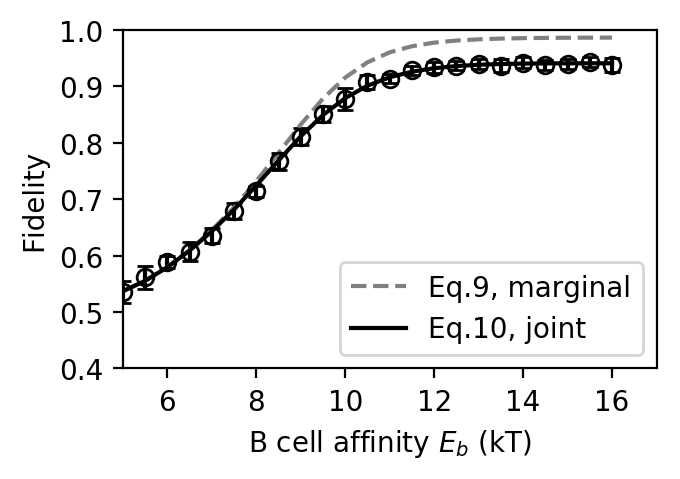

In [422]:
sc_plot = sc.ScanPlot(scaner=scanner2)
fig, ax = plt.subplots(figsize=(3.5, 2.5), dpi=200)
sc_plot.plot_qty('fidelity', errorbar=True, ax=ax, color='k')
plt.plot(np.arange(5, 16.5, 0.5), fidelity_list_marginal, '--', color='grey')
plt.plot(np.arange(5, 16.5, 0.5), fidelity_list_joint, '-k')
ax.set(xlim=(5, 17), ylim=(0.4, 1.0))
plt.xlabel('B cell affinity $E_b$ (kT)')
plt.ylabel('Fidelity')
plt.legend([ "Eq.9, marginal", "Eq.10, joint"])
plt.tight_layout()
plt.show()

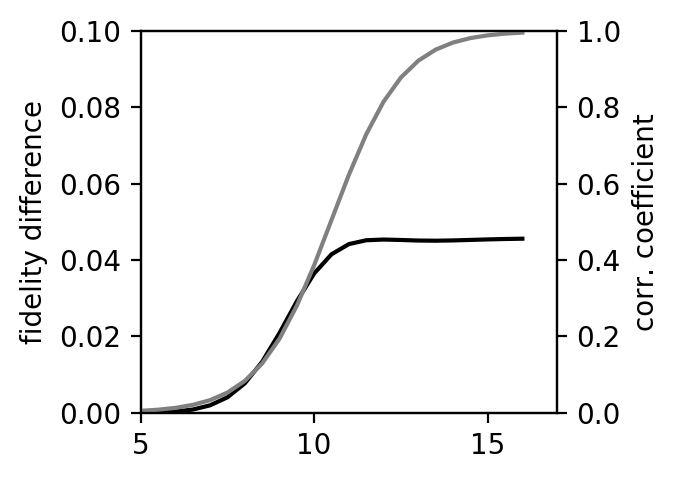

In [433]:
fig, ax = plt.subplots(figsize=(3.5, 2.5), dpi=200)

ax.plot(np.arange(5, 16.5, 0.5), np.asarray(fidelity_list_marginal) -  np.asarray(fidelity_list_joint), '-k')
ax.set(xlim=(5, 17), ylim=(0, 0.1), ylabel="fidelity difference")
tx =ax.twinx()
tx.plot(np.arange(5, 16.5, 0.5), corr_list, '-', color='grey')
tx.set(xlim=(5, 17), ylim=(0, 1.0))
plt.xlabel('B cell affinity $E_b$ (kT)')
plt.ylabel('corr. coefficient')
# plt.legend([ ""])
plt.tight_layout()
plt.show()